In [1]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers  import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import os

2024-06-21 19:18:07.587429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 19:18:07.587532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 19:18:07.710146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [3]:
image_size = 150

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=128,
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=128,
    color_mode='rgb',
    shuffle=True,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=128,
    color_mode='rgb',
    shuffle=True,
)

Found 4571 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

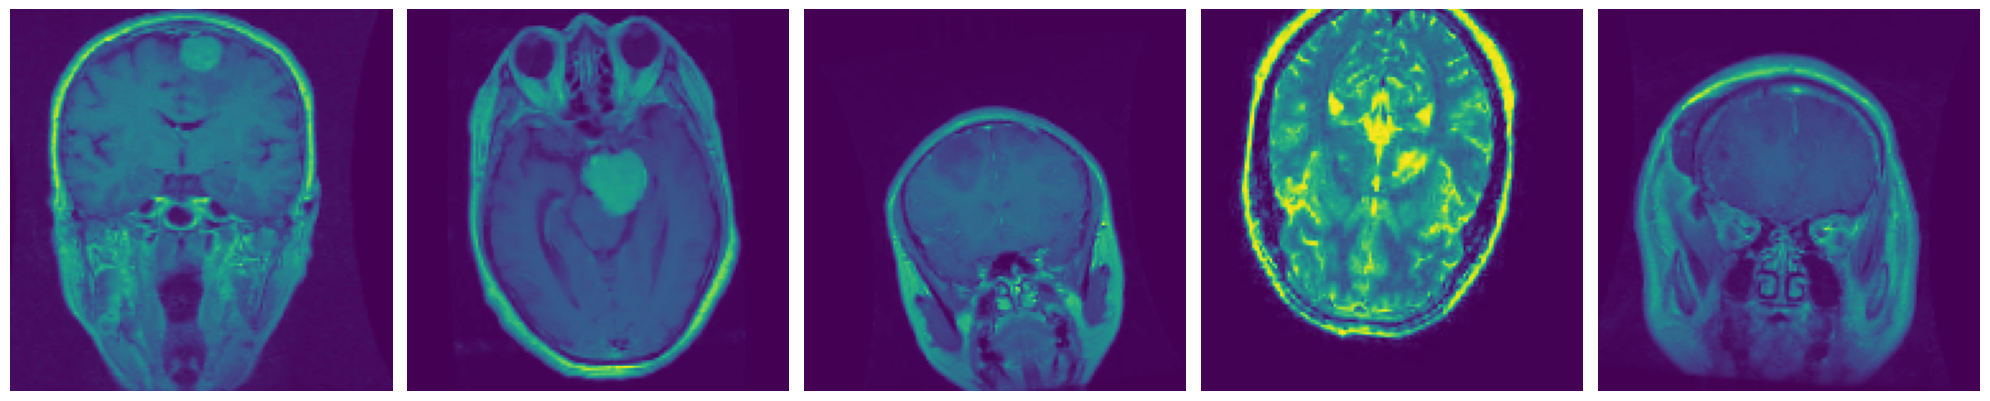

In [6]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [7]:
res_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model = res_model.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= res_model.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 40, 40,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 38, 38,    │          0 │ conv2_block1_0_c

 Total params: 23,572,996 (89.92 MB)

 Trainable params: 23,527,556 (89.75 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [9]:
BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,Checkpoint]

history = model.fit(train_generator,validation_data = validation_generator,epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718997607.231505      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718997607.313689      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/36 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5334 - loss: 1.1210

W0000 00:00:1718997684.640686      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6478 - loss: 0.8686

W0000 00:00:1718997704.812039      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718997710.492961      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.56095, saving model to model-01-0.62-1.56.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.6518 - loss: 0.8595 - val_accuracy: 0.6221 - val_loss: 1.5609 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.9249 - loss: 0.1949
Epoch 2: val_loss improved from 1.56095 to 1.05395, saving model to model-02-0.74-1.05.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 955ms/step - accuracy: 0.9250 - loss: 0.1947 - val_accuracy: 0.7443 - val_loss: 1.0540 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9631 - loss: 0.1045
Epoch 3: val_loss improved from 1.05395 to 0.66794, saving model to model-03-0.84-0.67.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 967ms/step - accuracy: 0.9630 - loss: 0.1047 - val_accuracy: 0.8359 - val_loss: 0.6679 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.9722 - loss: 0.0783
Epoch 4: val_loss improved fro

In [10]:
import os

# Ruta del archivo que quieres borrar
file_to_delete = '/kaggle/working/output/best/model-10-0.95-0.17.keras'

# Verificar si el archivo existe
if os.path.exists(file_to_delete):
    # Borrar el archivo
    os.remove(file_to_delete)
    print(f'Archivo {file_to_delete} borrado exitosamente.')
else:
    print(f'El archivo {file_to_delete} no existe.')

El archivo /kaggle/working/output/best/model-10-0.95-0.17.keras no existe.


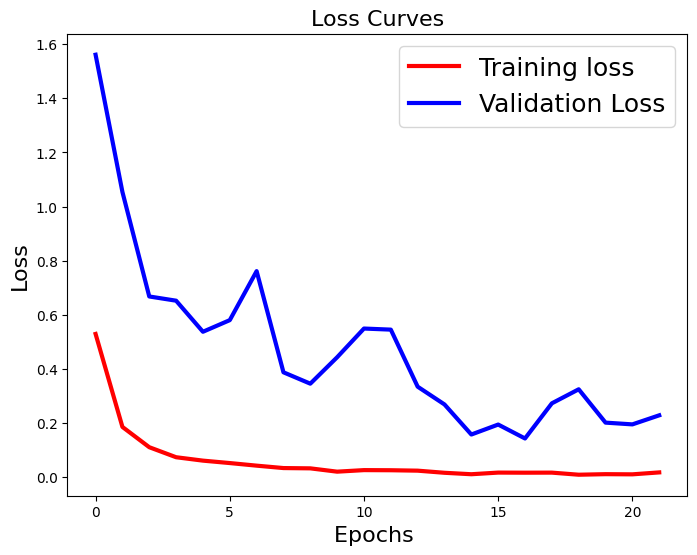

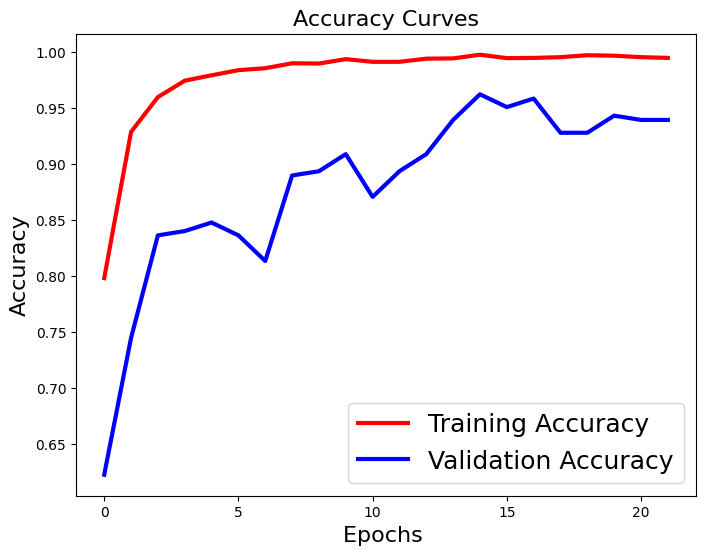

In [11]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()